In [1]:
import numpy as np
import cv2
import glob
from pathlib import Path
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
import pdb

from collections import deque

ROOT_PATH = '/home/downloads/carnd-p4-advanced-lane-lines'
#ROOT_PATH = 'C:/Users/jiangtao.fu/Downloads/carnd-p4-advanced-lane-lines'
CAMERA_CAL_PATH = (Path(ROOT_PATH)/'camera_cal').as_posix()
TEST_IMG_PATH = (Path(ROOT_PATH)/'test_images').as_posix()
CAMERA_CAL_FILE = (Path(ROOT_PATH)/'calibration.p').as_posix()

## Line class

Limit to reject update for fits (absolute value)
1. fit[0]: 1e-3
2. fit[1]: 10
3. fit[2]: 1e3

In [2]:
class Line():
    def __init__(self, name, buf_len=10, diff_len=5000, image_shape=(720, 1280), 
                 ym_per_pix = 30/720., xm_per_pix = 3.7/700, coef_diff_cap=[1e-3, 15, 1e3]):
        self.name = name
        self.detected = False 
        self.recent_fitx = deque(maxlen=buf_len)
        self.recent_fits = deque(maxlen=buf_len)
        self.current_fit = None
        self.coef_diffs = deque(maxlen=diff_len)
        #self.prev_coef_diffs
        self.allx = None
        self.ally = None
        self.image_shape = image_shape
        self.ploty = np.linspace(0, image_shape[0]-1, image_shape[0])
        self.ym_per_pix = ym_per_pix
        self.xm_per_pix = xm_per_pix
        self.coef_diff_cap = coef_diff_cap
        
    @property
    def curvature(self):
        fit = self.avg_fit
        y_eval = np.max(self.ploty)
        curv = ((1+(2*fit[0]*y_eval+fit[1])**2)**1.5)/np.absolute(2*fit[0])
        return curv

    @property
    def curvature_m(self):
        fitx = self.recent_fitx[-1]
        fit_m = np.polyfit(self.ploty*self.ym_per_pix, fitx*self.xm_per_pix, 2)
        y_eval = np.max(self.ploty)
        curv_m = ((1+(2*fit_m[0]*y_eval*self.ym_per_pix+fit_m[1])**2)**1.5)/np.absolute(2*fit_m[0])
        
        return curv_m
    
    @property
    def dist_to_lane(self):
        h, _ = self.image_shape
        fit = self.avg_fit
        
        # calculate lane position at height h
        line_x = fit[0]*h**2+fit[1]*h+fit[2]
        return line_x
    
    @property
    def avg_fit(self):
        #avg_fit = np.mean(np.array(self.recent_fits), axis=0)
        w = np.ones_like(self.recent_fits)
        w[len(w)//2:] = 0.5
        avg_fit = np.average(np.array(self.recent_fits), axis=0, weights=w)
        return avg_fit
    
    def fit_polynomial(self):
        num_pts = self.image_shape[0]

        try:
            fit = np.polyfit(self.ally, self.allx, 2)
            if self.current_fit is not None:
                coef_diff = fit - self.current_fit
                if ((np.absolute(coef_diff[0])<=self.coef_diff_cap[0]) and
                    (np.absolute(coef_diff[1])<=self.coef_diff_cap[1]) and
                    (np.absolute(coef_diff[2])<=self.coef_diff_cap[2])):
                    self.coef_diffs.append(fit-self.current_fit)
                    self.current_fit= fit
                    self.recent_fits.append(fit)

                    fit = self.avg_fit
                    fitx = fit[0]*self.ploty**2 + fit[1]*self.ploty + fit[2]
                    self.recent_fitx.append(fitx)
                    self.detected = True
                else:
                    self.detected = False
                    print('{} too large change in fit: previous: {}. current: {}. diff: {}'
                          .format(self.name, self.current_fit, fit, coef_diff))
            else:
                self.current_fit = fit
                self.recent_fits.append(fit)
                fit = self.avg_fit
                fitx = fit[0]*self.ploty**2 + fit[1]*self.ploty + fit[2]
                self.recent_fitx.append(fitx)
                self.detected = True
        except TypeError:
            self.detected = False

## Lane Detection Pipeline
1. Undistortion
2. Perspective transform
3. Binarization with color space and gradient
4. Lane pixels detection
    1. No prior
    2. With prior
5. Fit polynomials on detected pixels
6. Sanity check and update line properties (fits)
7. Calculate curvature and distance to the lane center
8. Unwarp the image and visualize the detected zone

### Undistortion and Perspective transform

In [3]:
class ImageProcessor:
    def __init__(self, calibration_file, img_shape=(720, 1280)):
        w = 350
        h = 0
        self.src = np.float32([[265, 680], [583, 460], [701, 460], [1044, 680]])
        self.dst = np.float32([[w, 720], [w, h], [img_shape[1]-w, h], [img_shape[1]-w, 720]])
        self.calibration_file = calibration_file
        # get calibration
        with open(self.calibration_file, 'rb') as f:
            self.calibration = pickle.load(f)

    @property
    def M(self):
        return cv2.getPerspectiveTransform(self.src, self.dst)
    
    @property 
    def Minv(self):
        return cv2.getPerspectiveTransform(self.dst, self.src)
    
    def undist_img(self, img):
        mtx = self.calibration['mtx']
        dist = self.calibration['dist']
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        
        return undist

    def transform_perspective(self, img, undist_flag=True):
        img_shape = img.shape[1], img.shape[0]
        if undist_flag:
            img = self.undist_img(img)
        warped = cv2.warpPerspective(img, self.M, img_shape)

        return warped

### Binarization

In [28]:
'''Binarnation module.

This module includes functions that select the yellow lines 
and white lines separately.
'''
def select_gradient_color(img, sx_thresh=(30, 100), l_thresh=(170, 255), b_thresh = (185, 255)):
    '''Binarize image by x gradients and color space.
    
    Paramters
    ---------
    img
        image array
    sx_thresh
        thresholds for Sobel x gradients
    l_thresh
        thresholds for L-channel
    b_thresh
        thresholds for B-channel
        
    Returns
    -------
    white_bin
        binary array for selecting white line pixels
    yellow_bin
        binary array for selecting yellow line pixels
    '''
    # convert into LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

    # l channel
    l = lab[:, :, 0]
    l = l*255./np.max(l)
    
    # b channel: normalize only yellow points
    b = lab[:, :, 2]
    if np.max(b) >= 175:
        b = b*255./np.max(b)
    
    # sobel x
    sobelx = cv2.Sobel(l, cv2.CV_64F, 1, 0) 
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx)) 
    
    # select yellow line with thresholds on B channel
    yellow_bin = np.zeros_like(b)
    mask = ((b > b_thresh[0]) & (b <= b_thresh[1]))
    yellow_bin[mask] = 255
    
    # select white line with Sobel x and L channel
    white_bin = np.zeros_like(scaled_sobel) 
    mask = ((scaled_sobel >= sx_thresh[0]) &
            (scaled_sobel <= sx_thresh[1]) & 
            (l > l_thresh[0]) & 
            (l <= l_thresh[1]))
    white_bin[mask] = 255

    return white_bin, yellow_bin

def combine_bins(white_bin, yellow_bin):
    combined_bin = np.zeros_like(white_bin)
    combined_bin[(white_bin==255) | (yellow_bin==255)] = 1
    
    return combined_bin

### Lane detection

In [29]:
def find_lane_pixels(binary_warped, nwindows=9, margin=100, minpix=50):
    '''Function to detect lane pixels by sliding windows. 
    
    Search for lane pixels by sliding windows on the preprocessed and binarized
    image. The search will start from the left and right peaks in the histogram 
    as the center point for the sliding window. 
    
    If the number of pixels found inthe window is larger than the minimum number
    of pixels, the middle point of the nonzero points in that window will become 
    the center point for the next search.
    
    Parameters
    ----------
    nwindow 
            number of sliding windows
    margin
            width of the window +/- margin
    minpix
            minimum number of pixels found to recenter window
    '''


    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & 
                          (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) &
                          (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) &
                           (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &
                           (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

In [30]:
def search_around_poly(binary_warped, left_line, right_line, margin=100):
    '''Function to search for lane pixels based on average fits.

    Search region will be within the margins of the fitted line based on the average of 
    coefficients of previous polynomial fits.
    '''
    # average fits
    left_fit = left_line.avg_fit
    right_fit = right_line.avg_fit

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) &
                      (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) &
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

In [31]:
def dist_to_middle(l_line, r_line):
    car_pos = l_line.image_shape[0]/2
    line_middle_pos = (r_line.dist_to_lane - l_line.dist_to_lane)
    
    return (car_pos - line_middle_pos)*l_line.xm_per_pix

In [32]:
def draw_lane_area(img, warped, img_processor, l_line, r_line, undistorted=False):
    img_shape = img.shape

    if undistorted == False:
        undist = img_processor.undist_img(img)
    else:
        undist = img
    left_fitx = l_line.recent_fitx[-1]
    right_fitx = r_line.recent_fitx[-1]
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, img_processor.Minv, (img_shape[1], img_shape[0])) 
    # Combine the result with the original image
    unwarped = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
     # add text (curvature and offset info) on the upper right of the blend
    car_to_middle_m = dist_to_middle(l_line, r_line)
    cv2.putText(unwarped, 'Curvature radius : {:.02f}m, {:.02f}m'.format(l_line.curvature_m, r_line.curvature_m), 
                (100, 60), cv2.FONT_HERSHEY_DUPLEX, 0.9, (255, 255, 255), 2, cv2.LINE_AA)
    direction = 'left' if car_to_middle_m <= 0 else 'right'
    cv2.putText(unwarped, 'Distance to {} of lane center: {:.2f}m'.format(direction, np.absolute(car_to_middle_m)), 
            (100, 100), cv2.FONT_HERSHEY_DUPLEX, 0.9, (255, 255, 255), 2, cv2.LINE_AA)
    
    return unwarped

### Test Individual Functions

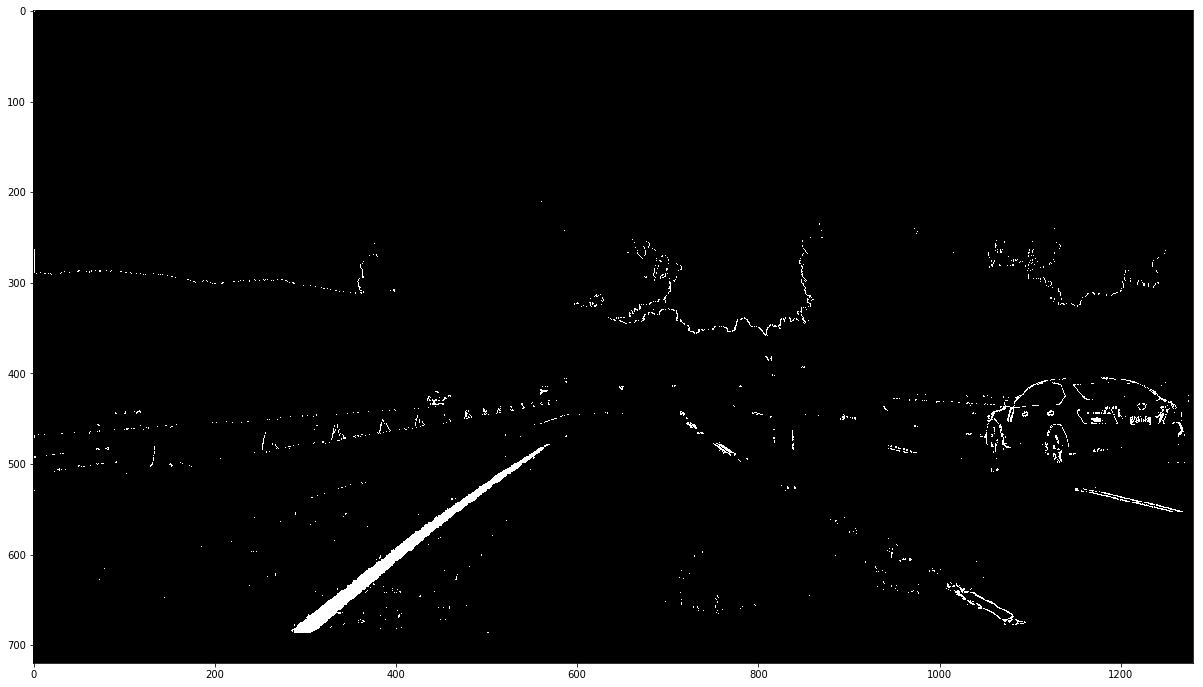

In [65]:
test_img_rgb = plt.imread(TEST_IMG_PATH+'/test1.jpg')
white_bin, yellow_bin = select_gradient_color(test_img_rgb, sx_thresh=(10, 100), l_thresh=(190, 255), b_thresh=(200, 255))
bin_warped = combine_bins(white_bin, yellow_bin)
fig, (ax1) = plt.subplots(1, 1, figsize=(24, 12))
ax1.imshow(bin_warped, cmap='gray')
plt.show()

### Pipeline

In [9]:
def draw_lines(bin_warped, l_line, r_line):
    scale = 1 if bin_warped.max() == 255 else 255
    if len(bin_warped.shape) == 2:
        color_bin = (np.dstack((bin_warped, bin_warped, bin_warped))*scale).astype(np.uint8)
    elif len(bin_warped.shape) == 3:
        color_bin = bin_warped
    
    # draw average of fitted lines 
    ploty = l_line.ploty
    l_pts = np.array([(x, y) for x, y in zip(l_line.recent_fitx[-1], ploty)], dtype=np.int32)
    l_pts = l_pts.reshape([-1, 1, 2])
    r_pts = np.array([(x, y) for x, y in zip(r_line.recent_fitx[-1], ploty)], dtype=np.int32)
    r_pts = r_pts.reshape([-1, 1, 2])
    cv2.polylines(color_bin, [l_pts], False, (219, 33, 54), 8)
    cv2.polylines(color_bin, [r_pts], False, (33, 115, 38), 8)
    
    # add diagnosis information
    if len(l_line.coef_diffs) > 0:
        
        cv2.putText(color_bin, 'Left fit diff: {:.3E}, {:.3E}, {:.3E}'
                    .format(l_line.coef_diffs[-1][0], 
                           l_line.coef_diffs[-1][1],
                           l_line.coef_diffs[-1][2]), 
                (100, 60), cv2.FONT_HERSHEY_DUPLEX, 0.9, (255, 255, 255), 2, cv2.LINE_AA)
    
    if len(r_line.coef_diffs) > 0:
        cv2.putText(color_bin, 'Right fit diff: {:.3E}, {:.3E}, {:.3E}'
                    .format(r_line.coef_diffs[-1][0], 
                            r_line.coef_diffs[-1][1],
                            r_line.coef_diffs[-1][2]), 
                (100, 100), cv2.FONT_HERSHEY_DUPLEX, 0.9, (255, 255, 255), 2, cv2.LINE_AA)
    return color_bin

def visualize(unwarped, color_bin):
    out_img = np.hstack([unwarped, color_bin])
    
    return out_img

In [10]:
def lane_detect_pipeline(img, camera_cal_file, diagnosis=False):
    image_processor = ImageProcessor(camera_cal_file)
    warped = image_processor.transform_perspective(img)
    w_bin, y_bin = select_gradient_color(warped)
    bin_warped = combine_bins(w_bin, y_bin)
    leftx, lefty, rightx, righty= find_lane_pixels(bin_warped)
    l_line = Line('left')
    r_line = Line('right')

    l_line.allx = leftx
    l_line.ally = lefty
    r_line.allx = rightx
    r_line.ally = righty

    l_line.fit_polynomial()
    r_line.fit_polynomial()
    
    # unwarped the image and plot the detected zone 
    unwarped = draw_lane_area(img, bin_warped, image_processor, l_line, r_line)
    if diagnosis:
        color_bin = draw_lines(bin_warped, l_line, r_line)
        out_img = visualize(unwarped, color_bin)
    else:
        out_img = unwarped
    return out_img

In [60]:
class LineDetector():
    def __init__(self, camera_cal_file, sx_thresh=(10, 100), l_thresh=(180, 255), b_thresh=(193, 255), 
                 diff_len=100, diagnosis=False):
        self.image_processor = ImageProcessor(camera_cal_file)
        self.l_line = Line('left', diff_len=diff_len)
        self.r_line = Line('right', diff_len=diff_len)
        self.diagnosis=diagnosis
        self.l_thresh=l_thresh
        self.b_thresh=b_thresh
        self.sx_thresh=sx_thresh
        
    def process(self, img):
        warped = self.image_processor.transform_perspective(img)
        w_bin, y_bin = select_gradient_color(warped, sx_thresh=self.sx_thresh, l_thresh=self.l_thresh, b_thresh=self.b_thresh)
        bin_warped = combine_bins(w_bin, y_bin)
        if (self.l_line.allx is None) or (self.r_line.allx is None): 
            leftx, lefty, rightx, righty= find_lane_pixels(bin_warped)
        else:
            leftx, lefty, rightx, righty= search_around_poly(bin_warped, self.l_line, self.r_line)
        self.l_line.allx = leftx
        self.l_line.ally = lefty
        self.r_line.allx = rightx
        self.r_line.ally = righty

        self.l_line.fit_polynomial()
        self.r_line.fit_polynomial()
        
        # unwarped the image and plot the detected zone 
        unwarped = draw_lane_area(img, bin_warped, self.image_processor, self.l_line, self.r_line)
        if self.diagnosis:
            color_bin = draw_lines(bin_warped, self.l_line, self.r_line)
            out_img = visualize(unwarped, color_bin)
        else:
            out_img = unwarped
        return out_img

### Test Pipeline Step by Step

In [61]:
ld = LineDetector(camera_cal_file=CAMERA_CAL_FILE, diagnosis=True)

### Test Pipeline on All Images

In [62]:
ld = LineDetector(camera_cal_file=CAMERA_CAL_FILE, diagnosis=True)

/home/downloads/carnd-p4-advanced-lane-lines/test_images/test4.jpg


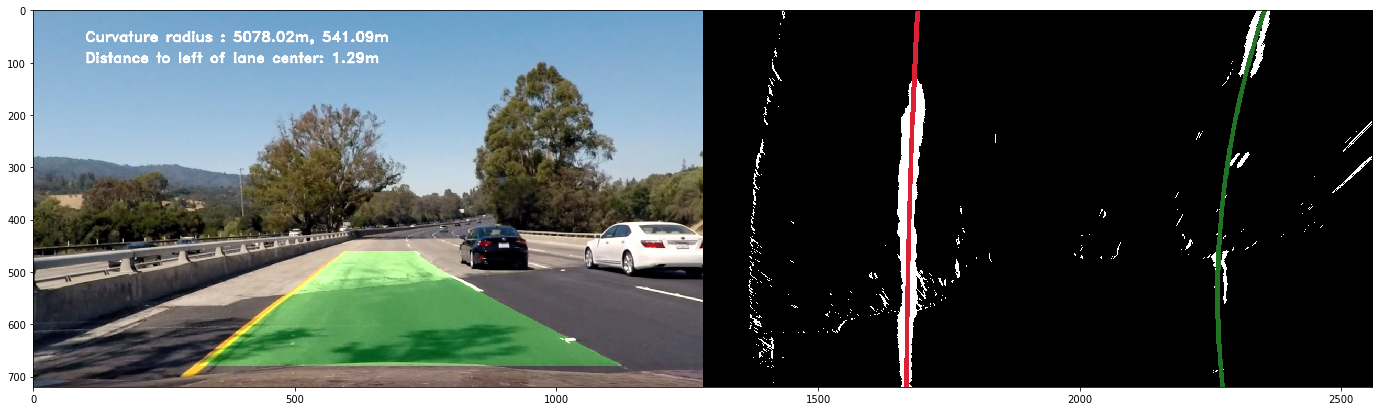

/home/downloads/carnd-p4-advanced-lane-lines/test_images/test3.jpg


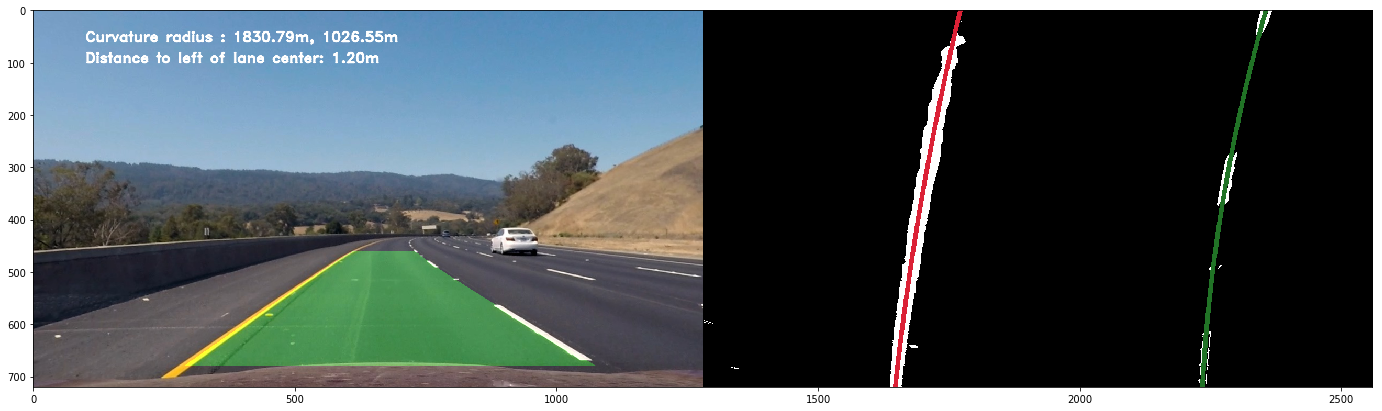

/home/downloads/carnd-p4-advanced-lane-lines/test_images/test1.jpg


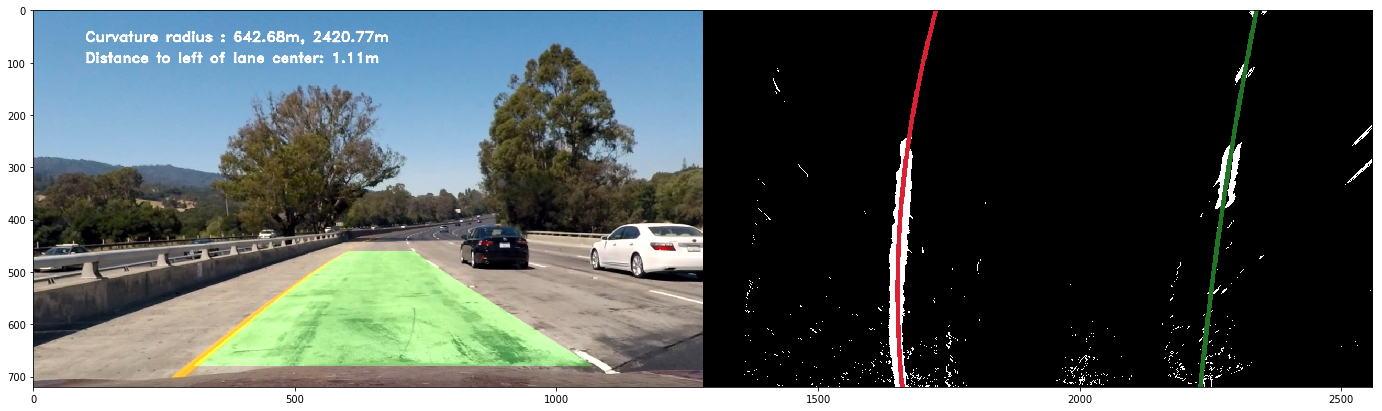

/home/downloads/carnd-p4-advanced-lane-lines/test_images/frame110.jpg


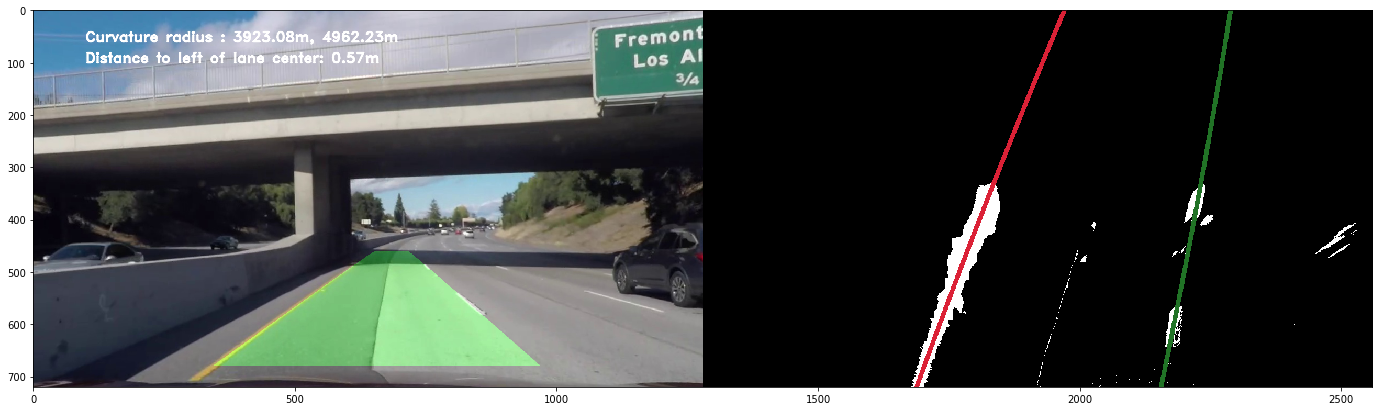

/home/downloads/carnd-p4-advanced-lane-lines/test_images/challenge02.jpg


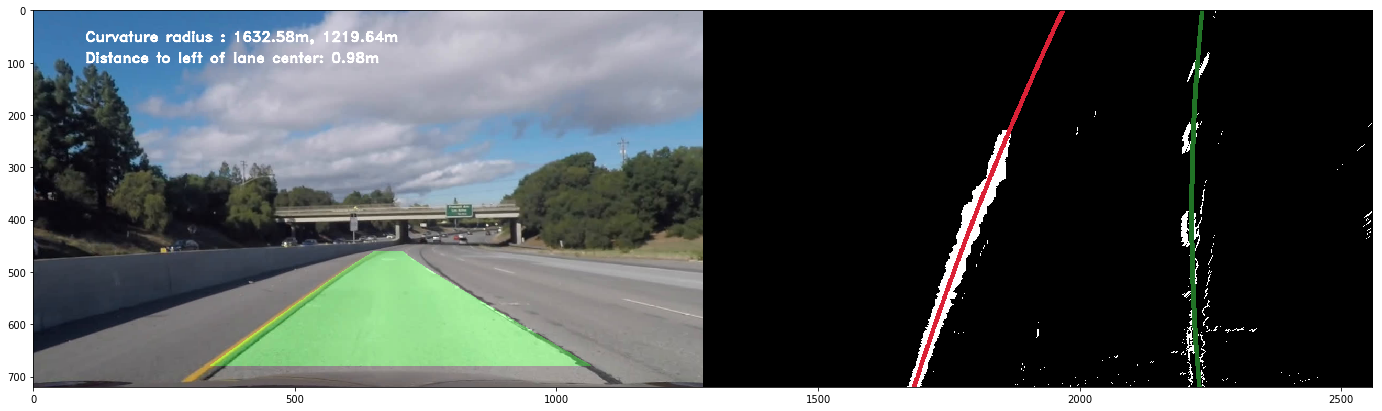

/home/downloads/carnd-p4-advanced-lane-lines/test_images/frame118.jpg


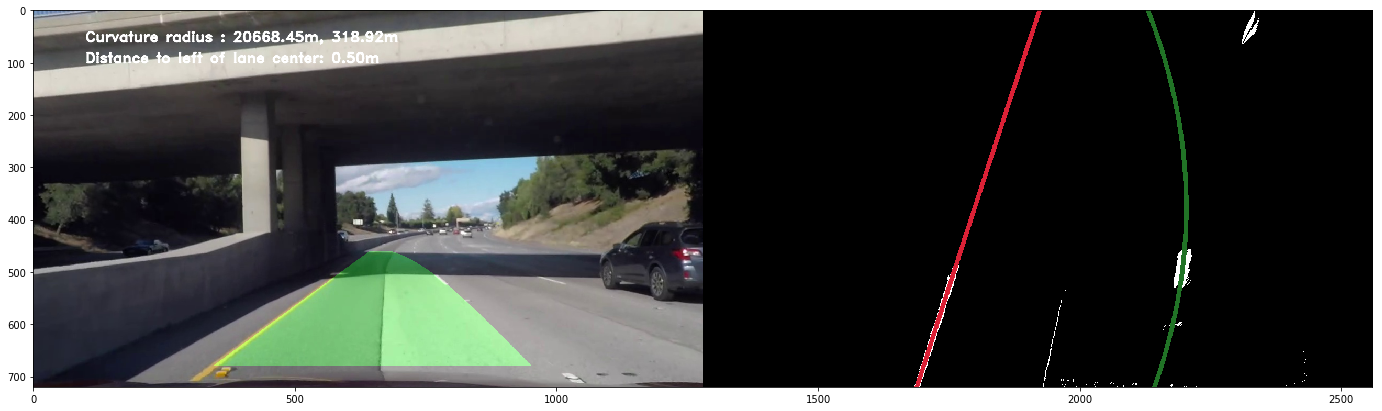

/home/downloads/carnd-p4-advanced-lane-lines/test_images/challenge03.jpg


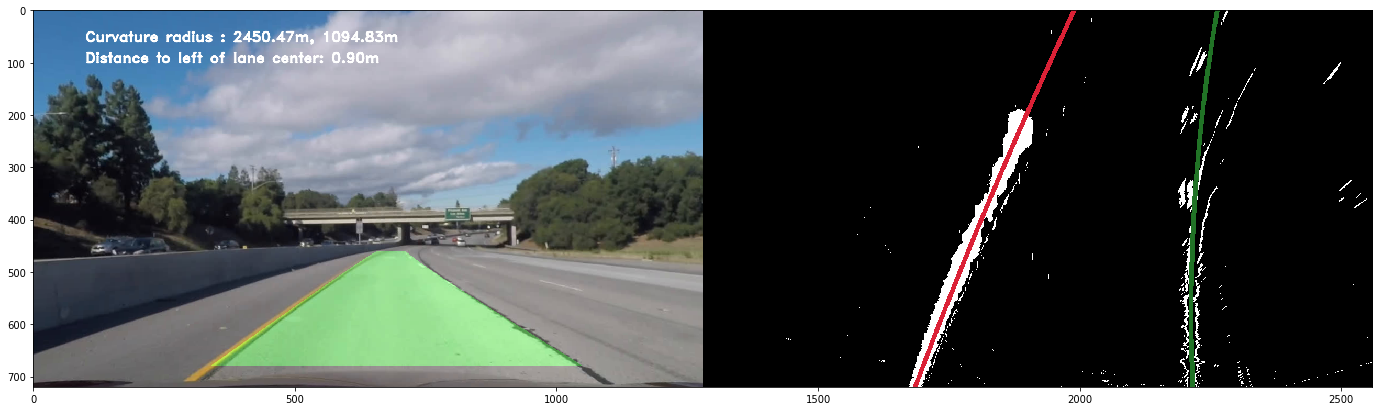

/home/downloads/carnd-p4-advanced-lane-lines/test_images/hard_challenge01.jpg


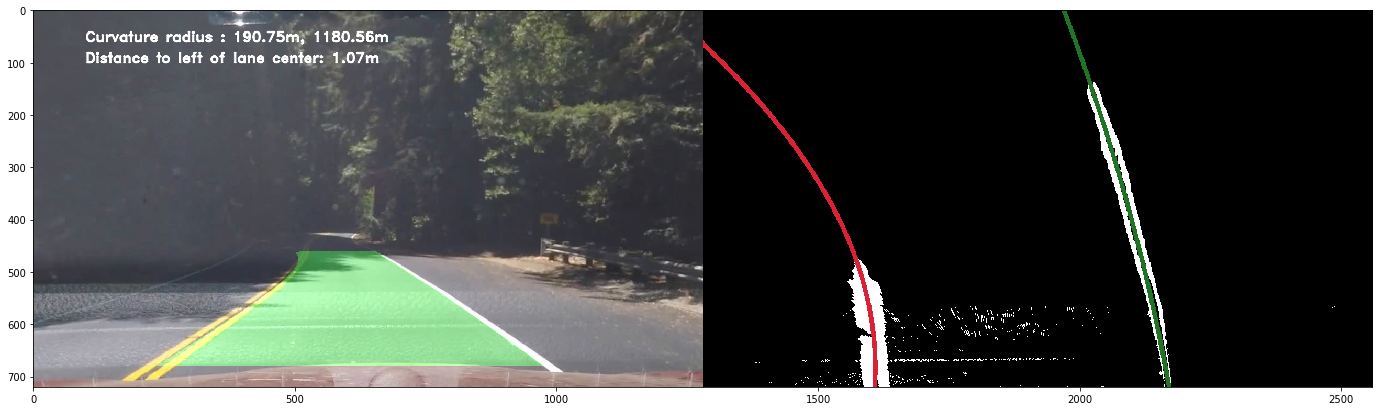

/home/downloads/carnd-p4-advanced-lane-lines/test_images/frame152.jpg


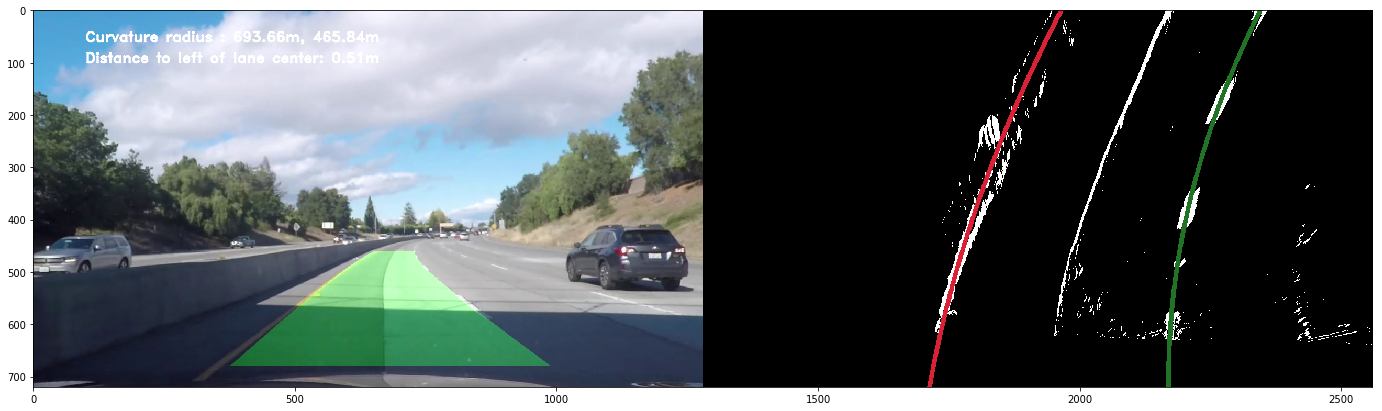

/home/downloads/carnd-p4-advanced-lane-lines/test_images/frame96.jpg


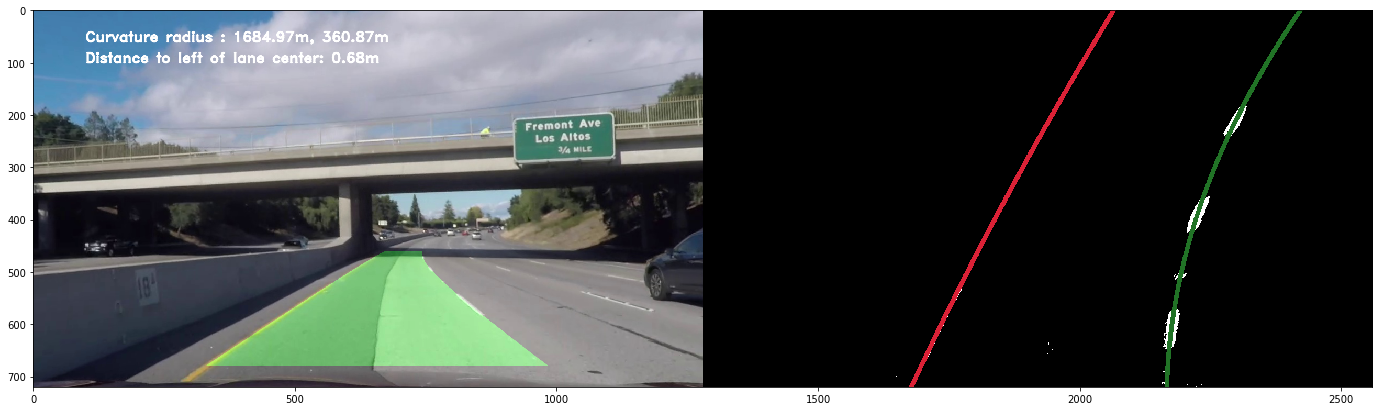

/home/downloads/carnd-p4-advanced-lane-lines/test_images/frame154.jpg


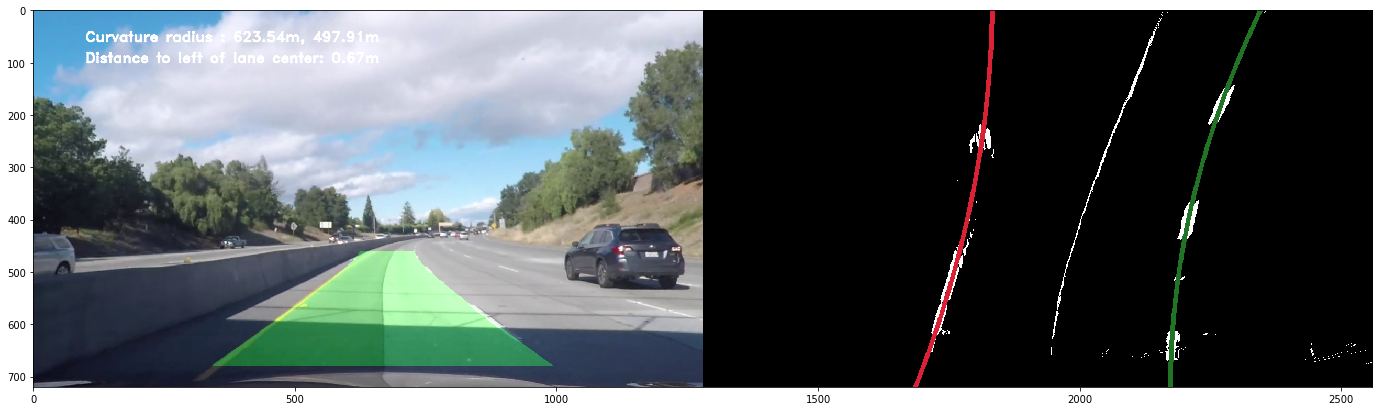

/home/downloads/carnd-p4-advanced-lane-lines/test_images/straight_lines2.jpg


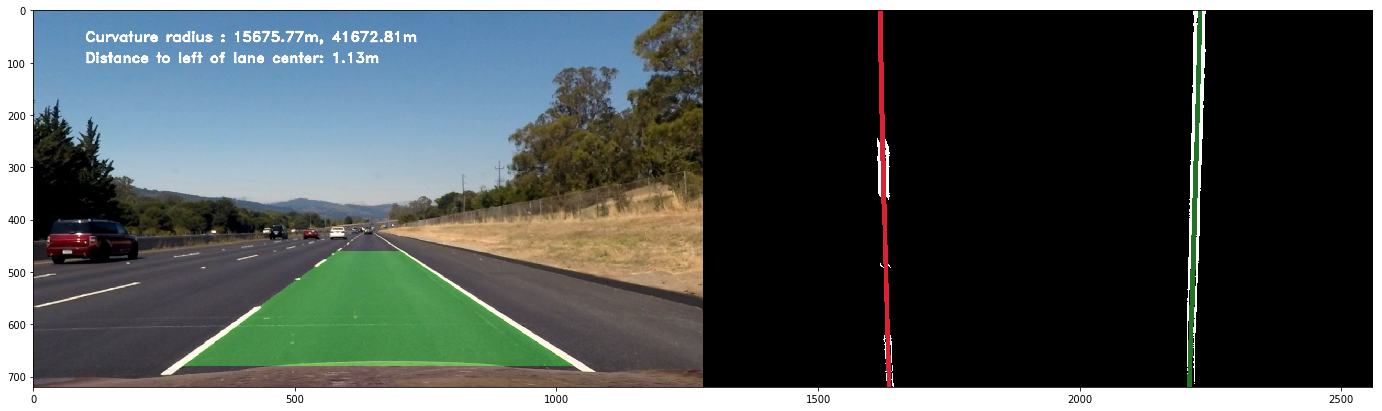

/home/downloads/carnd-p4-advanced-lane-lines/test_images/straight_lines1.jpg


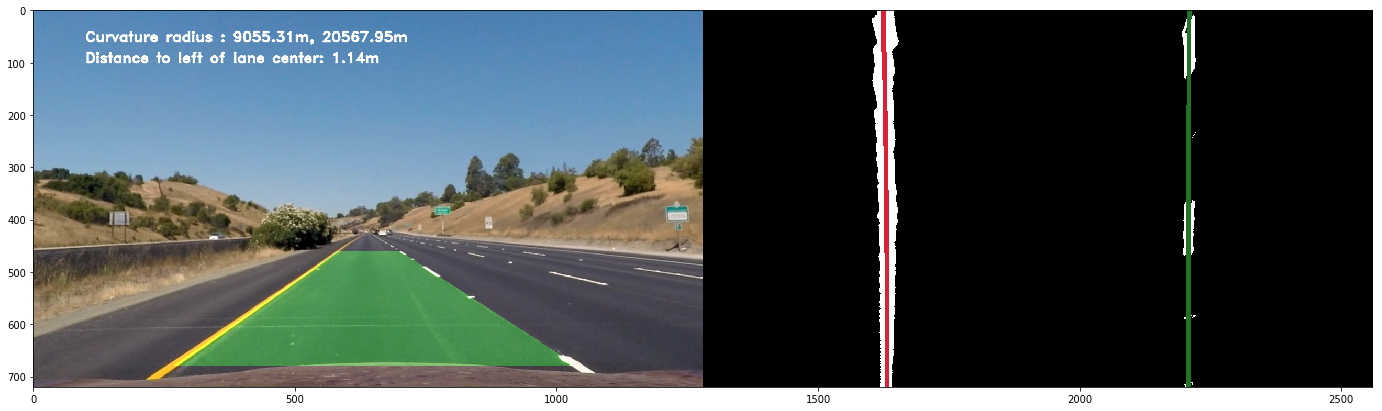

/home/downloads/carnd-p4-advanced-lane-lines/test_images/frame114.jpg


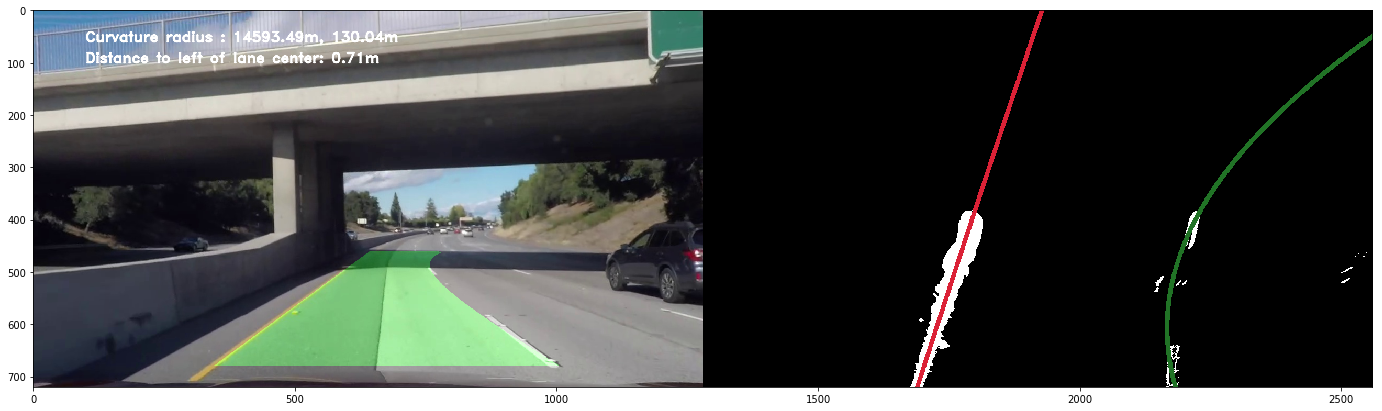

/home/downloads/carnd-p4-advanced-lane-lines/test_images/challenge01.jpg


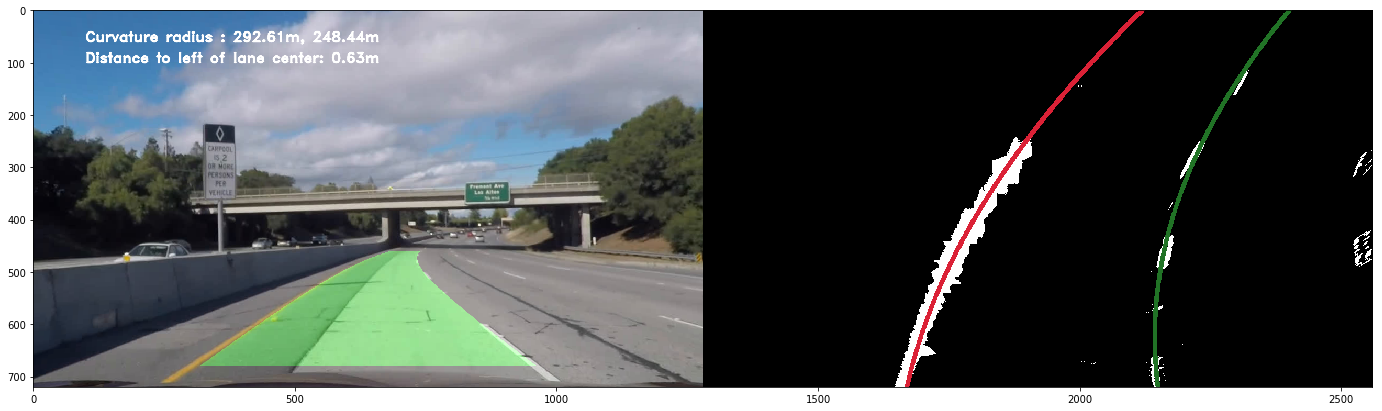

/home/downloads/carnd-p4-advanced-lane-lines/test_images/frame150.jpg


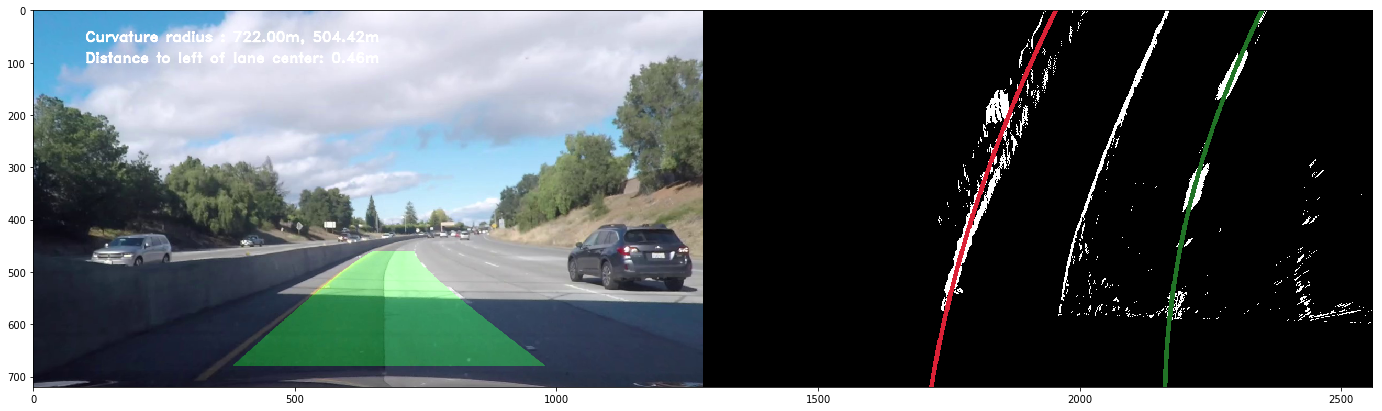

/home/downloads/carnd-p4-advanced-lane-lines/test_images/test6.jpg


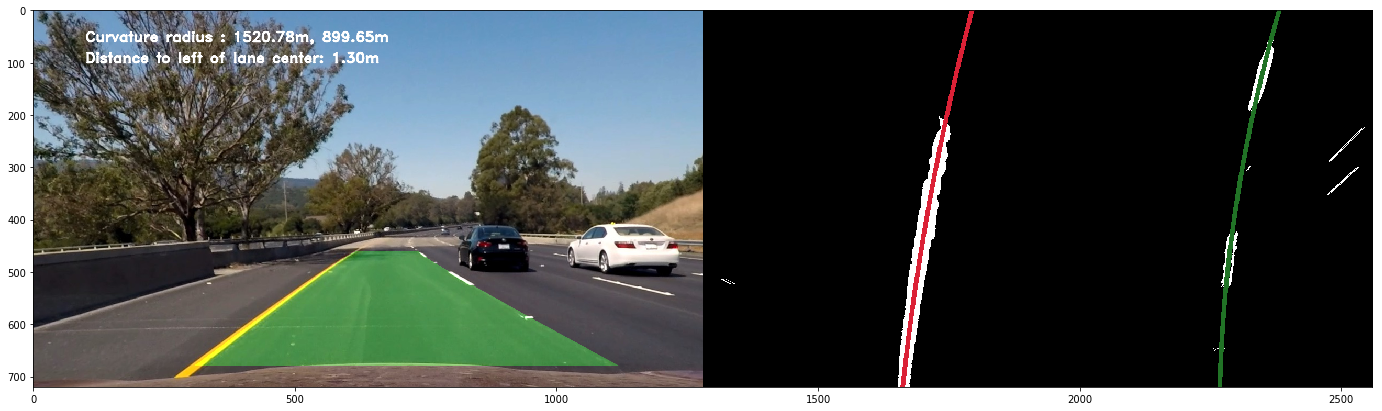

/home/downloads/carnd-p4-advanced-lane-lines/test_images/test2.jpg


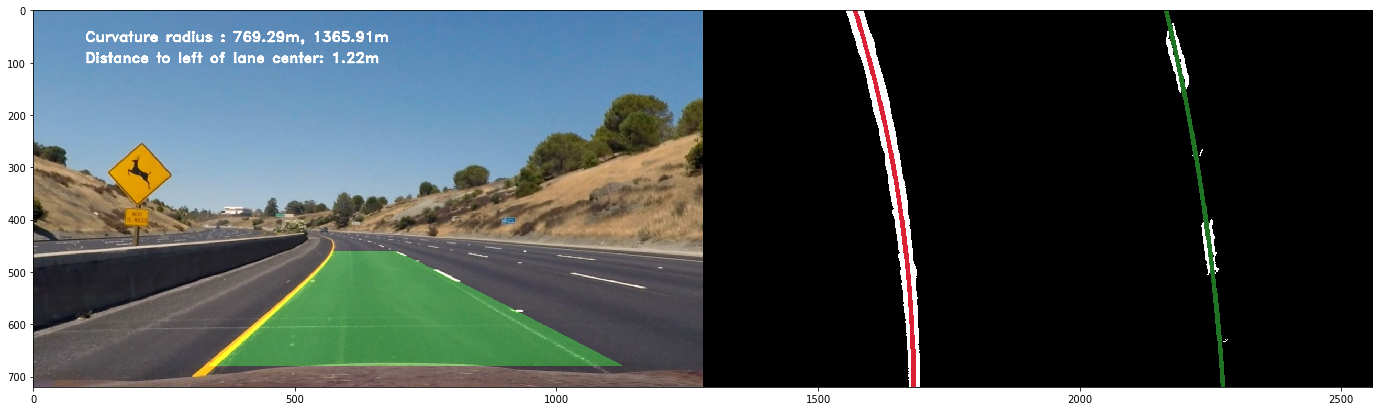

/home/downloads/carnd-p4-advanced-lane-lines/test_images/test5.jpg


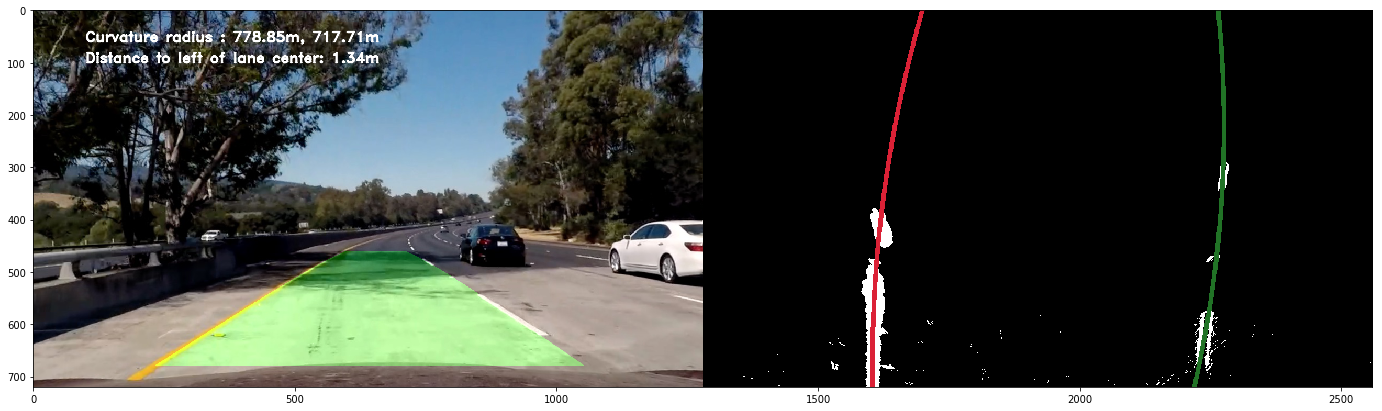

/home/downloads/carnd-p4-advanced-lane-lines/test_images/frame100.jpg


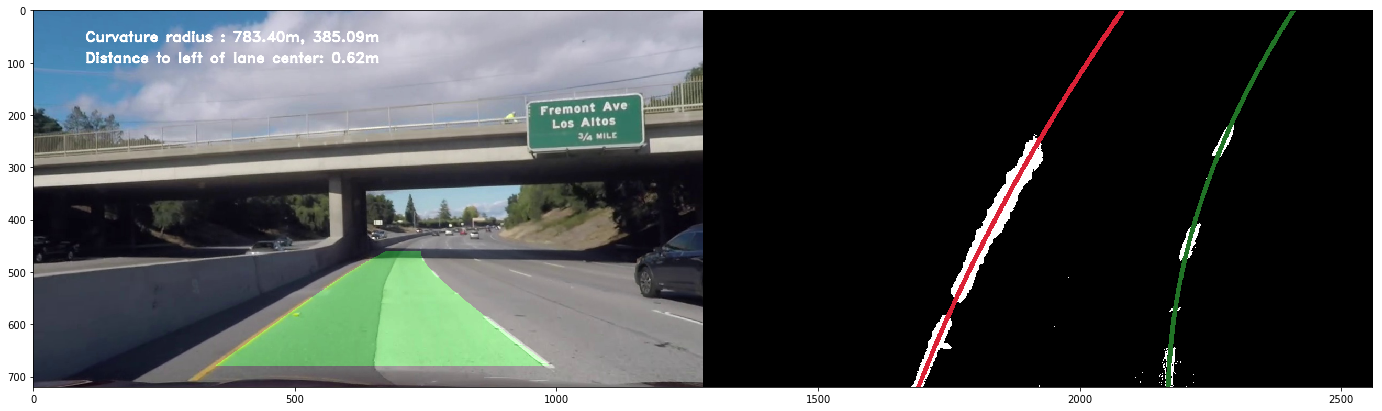

/home/downloads/carnd-p4-advanced-lane-lines/test_images/frame156.jpg


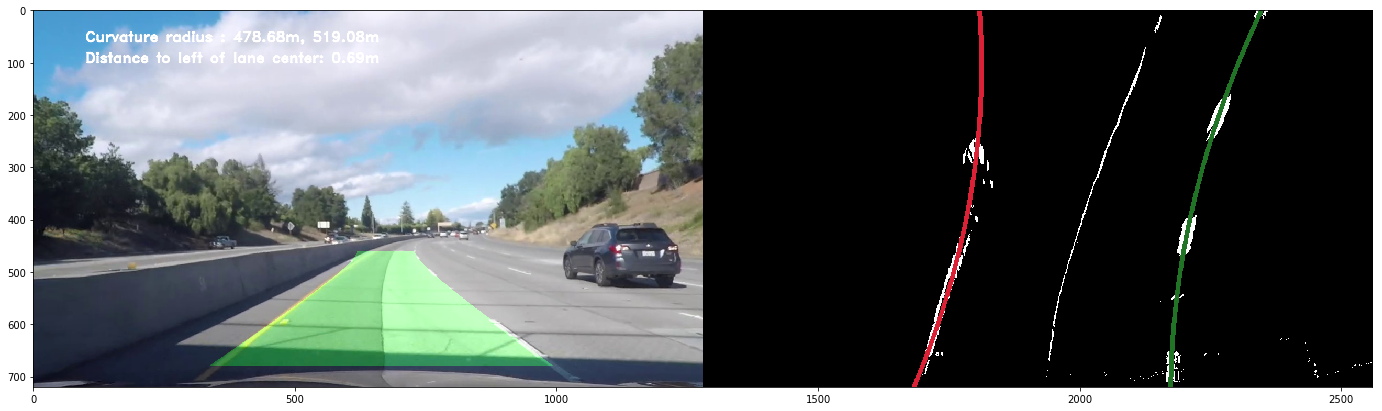

In [63]:
for img_path in Path(TEST_IMG_PATH).glob('*jpg'):
    print(img_path)
    test_img_rgb = plt.imread(img_path)
    ld = LineDetector(camera_cal_file=CAMERA_CAL_FILE, diagnosis=True)
    out_img = ld.process(test_img_rgb)
    
    fig, (ax1) = plt.subplots(1, 1, figsize=(24, 12))
    ax1.imshow(out_img)
    plt.show()

Sample Images from videos

In [211]:
import cv2
vidcap = cv2.VideoCapture((VIDEO_INPUT_PATH/'challenge_video.mp4').as_posix())
success,image = vidcap.read()
count = 0
while success:
    cv2.imwrite("/home/downloads/challenge_frames/frame%d.jpg" % count, image)     # save frame as JPEG file      
    success,image = vidcap.read()
    #print('Read a new frame: ', success)
    count += 1

### Test on Vidoes

In [191]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [192]:
VIDEO_INPUT_PATH = Path(ROOT_PATH)/'test_videos'
VIDEO_OUTPUT_PATH = Path(ROOT_PATH)/'test_videos_result'

To collect enough data to analyze the coefficient differences

In [61]:
ld = LineDetector(camera_cal_file=CAMERA_CAL_FILE, diff_len=5000, diagnosis=True)

clip1 = VideoFileClip((VIDEO_INPUT_PATH/'project_video.mp4').as_posix())
white_clip = clip1.fl_image(ld.process) #NOTE: this function expects color images!!
%time white_clip.write_videofile((VIDEO_OUTPUT_PATH/'project_video_result_diagnosis.mp4').as_posix(), audio=False, progress_bar=False)

[MoviePy] >>>> Building video /home/downloads/carnd-p4-advanced-lane-lines/test_videos_result/project_video_result_diagnosis.mp4
[MoviePy] Writing video /home/downloads/carnd-p4-advanced-lane-lines/test_videos_result/project_video_result_diagnosis.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: /home/downloads/carnd-p4-advanced-lane-lines/test_videos_result/project_video_result_diagnosis.mp4 

CPU times: user 3min 53s, sys: 4min 49s, total: 8min 43s
Wall time: 1min 37s


In [214]:
%%time
ld = LineDetector(camera_cal_file=CAMERA_CAL_FILE, diff_len=5000, diagnosis=False)

clip1 = VideoFileClip((VIDEO_INPUT_PATH/'project_video.mp4').as_posix())
white_clip = clip1.fl_image(ld.process) #NOTE: this function expects color images!!
%time white_clip.write_videofile((VIDEO_OUTPUT_PATH/'project_video_result.mp4').as_posix(), audio=False, progress_bar=False)

[MoviePy] >>>> Building video /home/downloads/carnd-p4-advanced-lane-lines/test_videos_result/project_video_result.mp4
[MoviePy] Writing video /home/downloads/carnd-p4-advanced-lane-lines/test_videos_result/project_video_result.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: /home/downloads/carnd-p4-advanced-lane-lines/test_videos_result/project_video_result.mp4 

CPU times: user 3min 52s, sys: 4min 41s, total: 8min 33s
Wall time: 1min 23s
CPU times: user 3min 52s, sys: 4min 41s, total: 8min 34s
Wall time: 1min 23s


In [18]:
print(np.percentile(ld.l_line.coef_diffs, [1, 5, 95, 99], axis=0))
print(np.percentile(ld.r_line.coef_diffs, [1, 5, 95, 99], axis=0))

[[-5.05208369e-05 -6.04400075e-02 -2.15242391e+01]
 [-2.17381817e-05 -2.46642088e-02 -9.51849081e+00]
 [ 2.11554279e-05  2.34014011e-02  9.53820996e+00]
 [ 5.89430225e-05  5.68971289e-02  2.39300546e+01]]
[[-7.65396893e-05 -4.80435789e-02 -1.90123685e+01]
 [-3.61965727e-05 -2.71714853e-02 -1.03198925e+01]
 [ 3.53912781e-05  3.24139765e-02  1.01488722e+01]
 [ 6.04465544e-05  7.05947368e-02  1.50836041e+01]]


### Challenge Video

In [227]:
%%time
ld = LineDetector(camera_cal_file=CAMERA_CAL_FILE, diff_len=5000, diagnosis=True)

clip1 = VideoFileClip((VIDEO_INPUT_PATH/'challenge_video.mp4').as_posix())
white_clip = clip1.fl_image(ld.process) #NOTE: this function expects color images!!
%time white_clip.write_videofile((VIDEO_OUTPUT_PATH/'challenge_video_result_diagnosis.mp4').as_posix(), audio=False, progress_bar=False)

[MoviePy] >>>> Building video /home/downloads/carnd-p4-advanced-lane-lines/test_videos_result/challenge_video_result_diagnosis.mp4
[MoviePy] Writing video /home/downloads/carnd-p4-advanced-lane-lines/test_videos_result/challenge_video_result_diagnosis.mp4
left too large change in fit: previous: [ 1.09038475e-04 -4.88739135e-01  7.03656079e+02]. current: [-2.70693959e-03  3.35881173e+00 -6.08600378e+02]. diff: [-2.81597806e-03  3.84755087e+00 -1.31225646e+03]
[MoviePy] Done.
[MoviePy] >>>> Video ready: /home/downloads/carnd-p4-advanced-lane-lines/test_videos_result/challenge_video_result_diagnosis.mp4 

CPU times: user 1min 30s, sys: 1min 48s, total: 3min 19s
Wall time: 34.4 s
CPU times: user 1min 30s, sys: 1min 49s, total: 3min 20s
Wall time: 34.8 s


In [213]:
ld = LineDetector(camera_cal_file=CAMERA_CAL_FILE, diff_len=5000, diagnosis=False)

clip1 = VideoFileClip((VIDEO_INPUT_PATH/'challenge_video.mp4').as_posix())
white_clip = clip1.fl_image(ld.process) #NOTE: this function expects color images!!
%time white_clip.write_videofile((VIDEO_OUTPUT_PATH/'challenge_video_result.mp4').as_posix(), audio=False, progress_bar=False)

[MoviePy] >>>> Building video /home/downloads/carnd-p4-advanced-lane-lines/test_videos_result/challenge_video_result.mp4
[MoviePy] Writing video /home/downloads/carnd-p4-advanced-lane-lines/test_videos_result/challenge_video_result.mp4
left too large change in fit: previous: [-1.98139541e-04 -8.10198490e-02  5.68820757e+02]. current: [-3.85252189e-03  4.91395458e+00 -1.13517103e+03]. diff: [-3.65438235e-03  4.99497443e+00 -1.70399179e+03]
[MoviePy] Done.
[MoviePy] >>>> Video ready: /home/downloads/carnd-p4-advanced-lane-lines/test_videos_result/challenge_video_result.mp4 

CPU times: user 1min 27s, sys: 1min 52s, total: 3min 19s
Wall time: 31.4 s
